# Score Matching and Diffusion Models
## A Pedagogical Introduction with Single-Noise Denoising Score Matching

This notebook introduces **score-based generative models**, an alternative perspective on diffusion models. Instead of predicting noise, we directly learn the **score function** — the gradient of the log probability density.


## 1. What is the Score Function?

### Definition

The **score function** of a probability distribution $p(x)$ is the gradient of its log-density:

$$s(x) = \nabla_x \log p(x)$$

### Intuition

The score tells us: **"In which direction should I move to reach higher probability regions?"**

- Points **toward** regions of high density
- Has **zero magnitude** at the mode (peak) of the distribution
- Is **undefined** where $p(x) = 0$

### Example: Gaussian Distribution

For $p(x) = \mathcal{N}(x; \mu, \sigma^2)$:

$$\log p(x) = -\frac{(x - \mu)^2}{2\sigma^2} + \text{const}$$

$$s(x) = \nabla_x \log p(x) = -\frac{x - \mu}{\sigma^2}$$

The score points toward the mean $\mu$!

### Why Learn the Score?

1. **Avoids partition function:** Unlike learning $p(x)$ directly, we don't need to compute $Z = \int p(x) dx$
2. **Enables sampling:** We can use Langevin dynamics to sample using only the score
3. **Connection to denoising:** The score of noisy data equals the denoising direction

## 2. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Using device: cpu


### Visualizing the Score: Gaussian Example

Let's first visualize what the score function looks like for a simple 2D Gaussian:

/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_45413/3831472613.py:70: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_45413/3831472613.py:70: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_45413/3831472613.py:70: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.tight_layout()
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/oualid/miniconda3/envs/dl_finance/lib/pyt

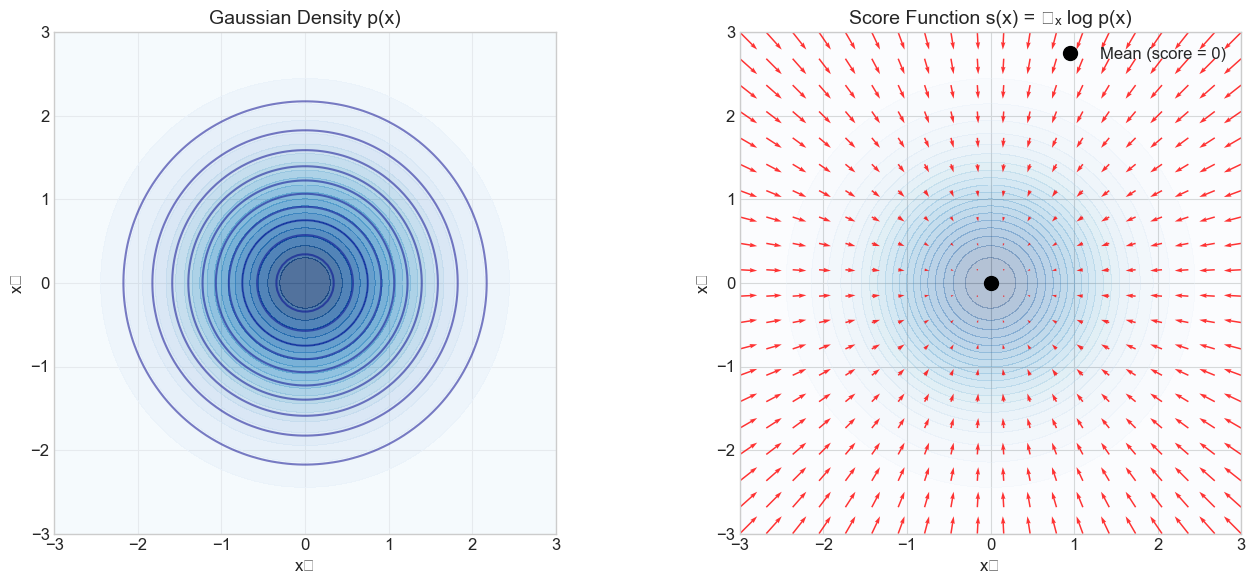

Observation: All arrows point toward the mean — the score guides us to high-density regions!


In [2]:
def gaussian_score(x, mu, sigma):
    """
    Analytical score for a Gaussian distribution.
    
    s(x) = -(x - μ) / σ²
    
    Args:
        x: Points to evaluate, shape (n, 2)
        mu: Mean, shape (2,)
        sigma: Standard deviation (scalar)
    
    Returns:
        score: Gradient of log p(x), shape (n, 2)
    """
    return -(x - mu) / (sigma ** 2)


def gaussian_density(x, mu, sigma):
    """Gaussian probability density."""
    d = x.shape[-1]
    diff = x - mu
    exponent = -0.5 * np.sum(diff ** 2, axis=-1) / (sigma ** 2)
    norm = (2 * np.pi * sigma ** 2) ** (d / 2)
    return np.exp(exponent) / norm


# Create grid for visualization
x_range = np.linspace(-3, 3, 20)
y_range = np.linspace(-3, 3, 20)
X, Y = np.meshgrid(x_range, y_range)
grid_points = np.stack([X.flatten(), Y.flatten()], axis=1)

# Gaussian parameters
mu = np.array([0.0, 0.0])
sigma = 1.0

# Compute score at each grid point
scores = gaussian_score(grid_points, mu, sigma)
U = scores[:, 0].reshape(X.shape)
V = scores[:, 1].reshape(X.shape)

# Compute density for background
x_dense = np.linspace(-3, 3, 100)
y_dense = np.linspace(-3, 3, 100)
X_dense, Y_dense = np.meshgrid(x_dense, y_dense)
grid_dense = np.stack([X_dense.flatten(), Y_dense.flatten()], axis=1)
density = gaussian_density(grid_dense, mu, sigma).reshape(X_dense.shape)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Density contours
axes[0].contourf(X_dense, Y_dense, density, levels=20, cmap='Blues', alpha=0.7)
axes[0].contour(X_dense, Y_dense, density, levels=10, colors='darkblue', alpha=0.5)
axes[0].set_title('Gaussian Density p(x)', fontsize=14)
axes[0].set_xlabel('x₁')
axes[0].set_ylabel('x₂')
axes[0].set_aspect('equal')

# Right: Score field (arrows)
axes[1].contourf(X_dense, Y_dense, density, levels=20, cmap='Blues', alpha=0.3)
axes[1].quiver(X, Y, U, V, color='red', alpha=0.8)
axes[1].plot(mu[0], mu[1], 'ko', markersize=10, label='Mean (score = 0)')
axes[1].set_title('Score Function s(x) = ∇ₓ log p(x)', fontsize=14)
axes[1].set_xlabel('x₁')
axes[1].set_ylabel('x₂')
axes[1].set_aspect('equal')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Observation: All arrows point toward the mean — the score guides us to high-density regions!")

## 3. The Problem with Vanilla Score Matching

### The Original Score Matching Objective

Hyvärinen (2005) showed we can learn the score by minimizing:

$$\mathcal{L}_{SM} = \mathbb{E}_{p(x)} \left[ \frac{1}{2} \|s_\theta(x) - \nabla_x \log p(x)\|^2 \right]$$

This can be rewritten (via integration by parts) as:

$$\mathcal{L}_{SM} = \mathbb{E}_{p(x)} \left[ \frac{1}{2} \|s_\theta(x)\|^2 + \text{tr}(\nabla_x s_\theta(x)) \right]$$

### The Problem: Low-Density Regions

In practice, this fails because:

1. **Data lives on a manifold:** Real data often lies on a lower-dimensional manifold
2. **Score is undefined off-manifold:** Where $p(x) = 0$, the score doesn't exist
3. **No training signal:** We have no samples in low-density regions to learn from

### Visualization: The Manifold Problem

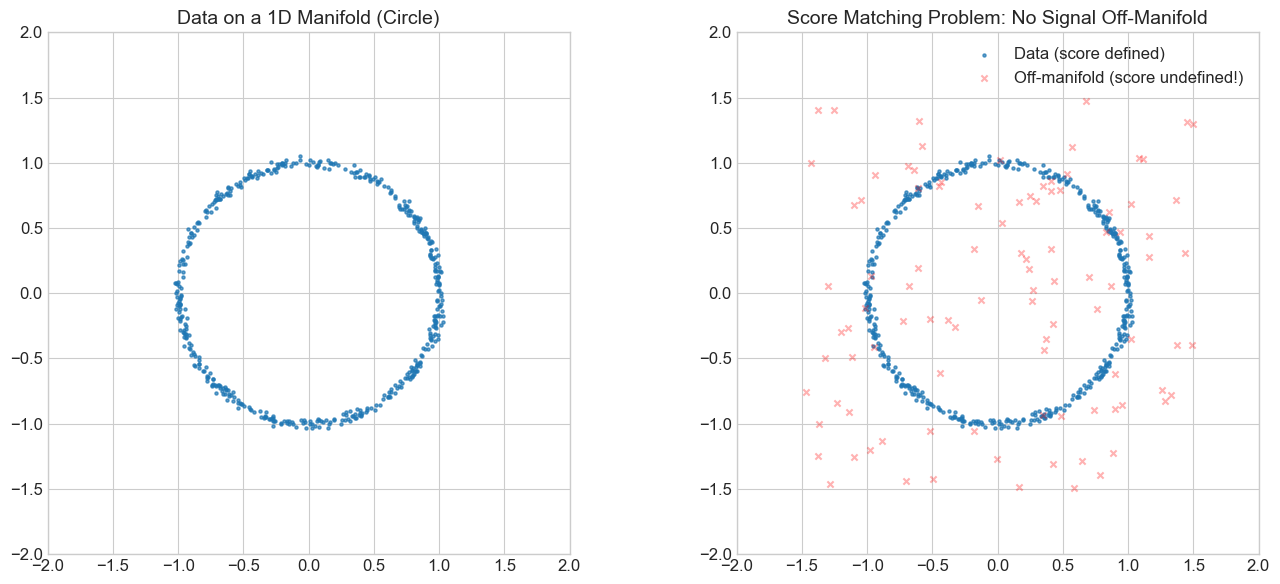

Problem: If we start sampling from a random point (red X), we don't know which way to go!


In [3]:
# Generate data on a 1D manifold (circle) in 2D space
n_samples = 500
theta = np.random.uniform(0, 2 * np.pi, n_samples)
radius = 1.0
circle_data = np.stack([radius * np.cos(theta), radius * np.sin(theta)], axis=1)
circle_data += 0.02 * np.random.randn(n_samples, 2)  # tiny noise

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Data on manifold
axes[0].scatter(circle_data[:, 0], circle_data[:, 1], s=5, alpha=0.7)
axes[0].set_title('Data on a 1D Manifold (Circle)', fontsize=14)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')

# Right: Where is the score defined?
# Show that off the circle, we have no information
axes[1].scatter(circle_data[:, 0], circle_data[:, 1], s=5, alpha=0.7, label='Data (score defined)')

# Add some off-manifold points
off_manifold = np.random.uniform(-1.5, 1.5, (100, 2))
axes[1].scatter(off_manifold[:, 0], off_manifold[:, 1], s=20, c='red', alpha=0.3, 
                marker='x', label='Off-manifold (score undefined!)')
axes[1].set_title('Score Matching Problem: No Signal Off-Manifold', fontsize=14)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect('equal')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Problem: If we start sampling from a random point (red X), we don't know which way to go!")

## 4. The Solution: Denoising Score Matching (DSM)

### Key Insight (Vincent, 2011)

Instead of learning the score of the data distribution $p(x)$, we learn the score of a **noisy** version $p_\sigma(\tilde{x})$:

$$p_\sigma(\tilde{x}) = \int p(x) \, q_\sigma(\tilde{x} | x) \, dx$$

where $q_\sigma(\tilde{x} | x) = \mathcal{N}(\tilde{x}; x, \sigma^2 I)$ adds Gaussian noise.

### The Beautiful Result

The score of the noisy distribution has a simple form:

$$\nabla_{\tilde{x}} \log q_\sigma(\tilde{x} | x) = -\frac{\tilde{x} - x}{\sigma^2} = -\frac{\epsilon}{\sigma}$$

where $\epsilon = \tilde{x} - x$ is the noise that was added.

### DSM Training Objective

$$\mathcal{L}_{DSM} = \mathbb{E}_{p(x)} \mathbb{E}_{q_\sigma(\tilde{x}|x)} \left[ \left\| s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) \right\|^2 \right]$$

Which simplifies to:

$$\mathcal{L}_{DSM} = \mathbb{E}_{x, \epsilon} \left[ \left\| s_\theta(x + \sigma\epsilon) + \frac{\epsilon}{\sigma} \right\|^2 \right]$$

### Why This Works

1. **Noise fills the space:** Adding noise makes $p_\sigma(\tilde{x}) > 0$ everywhere
2. **Training signal everywhere:** We can now learn the score at any point
3. **Connection to denoising:** The score points from noisy data back to clean data!

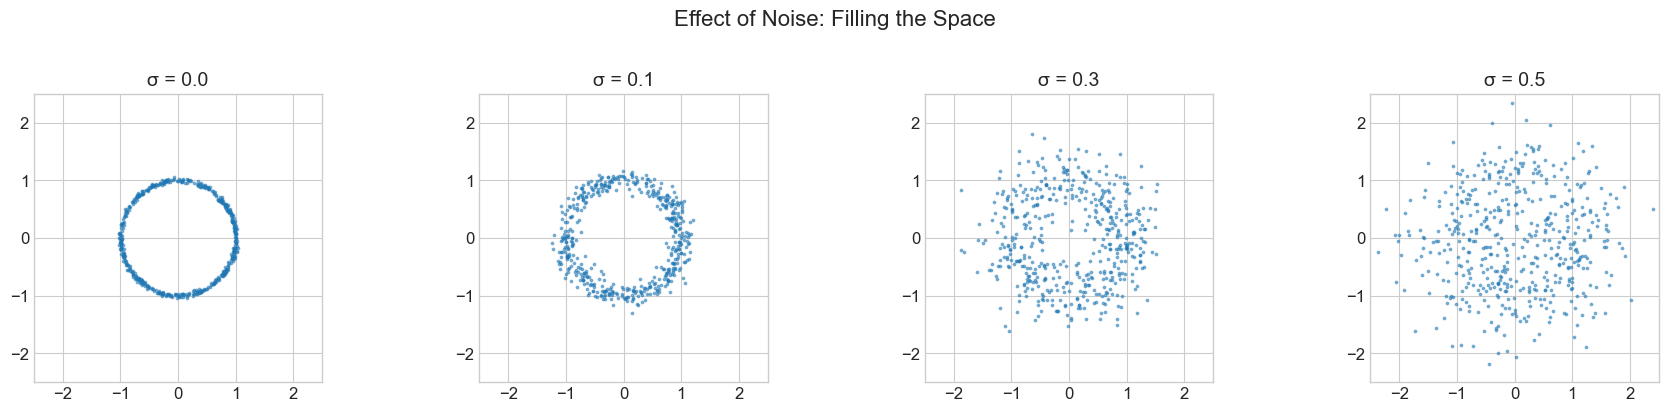

With noise, the distribution spreads out — now we have training signal everywhere!


In [4]:
# Visualize how noise "fills in" the space
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

noise_levels = [0.0, 0.1, 0.3, 0.5]

for idx, sigma in enumerate(noise_levels):
    if sigma == 0:
        noisy_data = circle_data.copy()
    else:
        noisy_data = circle_data + sigma * np.random.randn(n_samples, 2)
    
    axes[idx].scatter(noisy_data[:, 0], noisy_data[:, 1], s=3, alpha=0.5)
    axes[idx].set_title(f'σ = {sigma}', fontsize=14)
    axes[idx].set_xlim(-2.5, 2.5)
    axes[idx].set_ylim(-2.5, 2.5)
    axes[idx].set_aspect('equal')

plt.suptitle('Effect of Noise: Filling the Space', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("With noise, the distribution spreads out — now we have training signal everywhere!")

## 5. Toy Datasets

We'll use two datasets:
1. **Mixture of Gaussians:** Has analytical score for validation
2. **2D Spiral:** Visually interesting, tests complex distributions

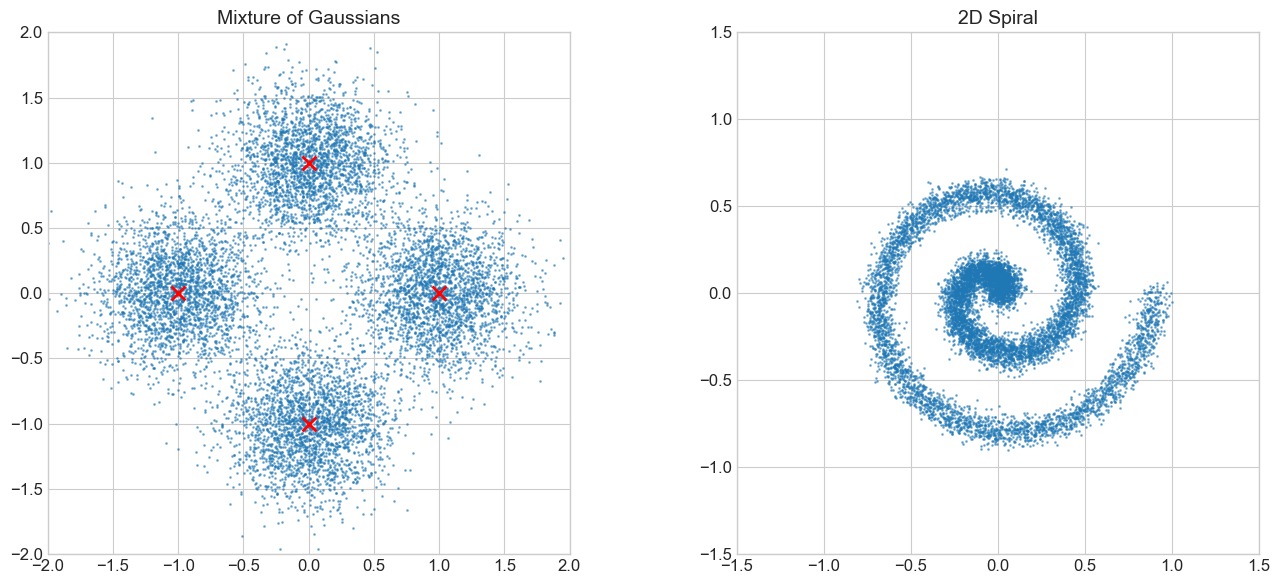

In [5]:
def generate_mixture_of_gaussians(n_samples=10000, n_components=4, std=0.3):
    """
    Generate a mixture of 2D Gaussians arranged in a circle.
    """
    samples_per_component = n_samples // n_components
    
    # Place means on a circle
    angles = np.linspace(0, 2 * np.pi, n_components, endpoint=False)
    means = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    
    data = []
    for i in range(n_components):
        samples = means[i] + std * np.random.randn(samples_per_component, 2)
        data.append(samples)
    
    data = np.concatenate(data, axis=0)
    np.random.shuffle(data)
    return data.astype(np.float32), means, std


def generate_spiral_data(n_samples=10000, noise=0.05):
    """
    Generate a 2D spiral dataset.
    """
    t = np.linspace(0, 4 * np.pi, n_samples)
    r = t / (4 * np.pi)
    x = r * np.cos(t)
    y = r * np.sin(t)
    X = np.stack([x, y], axis=1)
    X += noise * np.random.randn(n_samples, 2)
    X = X / np.abs(X).max()
    return X.astype(np.float32)


# Generate both datasets
mog_data, mog_means, mog_std = generate_mixture_of_gaussians(n_samples=10000)
spiral_data = generate_spiral_data(n_samples=10000)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(mog_data[:, 0], mog_data[:, 1], s=1, alpha=0.5)
axes[0].scatter(mog_means[:, 0], mog_means[:, 1], c='red', s=100, marker='x', linewidths=2)
axes[0].set_title('Mixture of Gaussians', fontsize=14)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')

axes[1].scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, alpha=0.5)
axes[1].set_title('2D Spiral', fontsize=14)
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

### Analytical Score for Mixture of Gaussians

For a mixture of Gaussians, we can compute the true score analytically:

$$p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x; \mu_k, \sigma^2 I)$$

$$\nabla_x \log p(x) = \frac{\sum_k \pi_k \, \mathcal{N}(x; \mu_k, \sigma^2) \cdot (-\frac{x - \mu_k}{\sigma^2})}{\sum_k \pi_k \, \mathcal{N}(x; \mu_k, \sigma^2)}$$

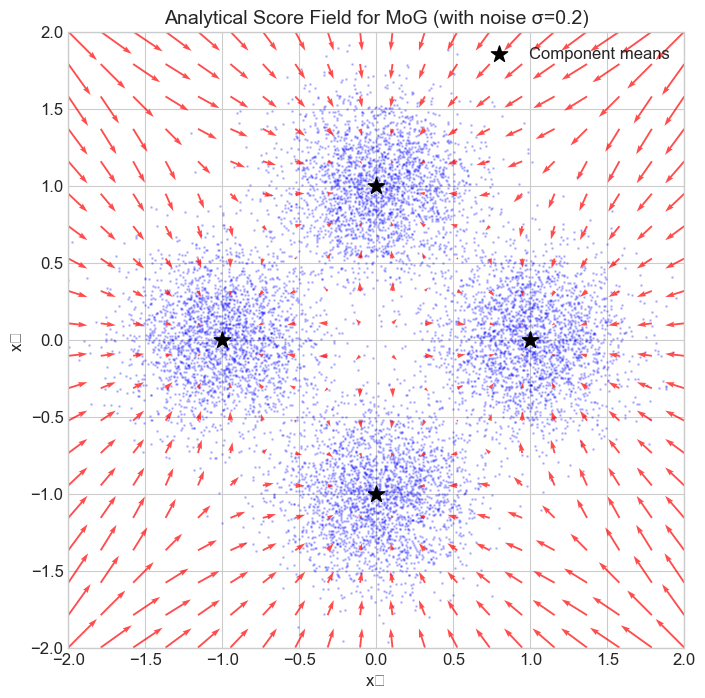

Arrows point toward the nearest component — this is what we want to learn!


In [6]:
def mog_score_analytical(x, means, std):
    """
    Compute the analytical score for a mixture of Gaussians.
    
    Args:
        x: Points to evaluate, shape (n, 2)
        means: Component means, shape (k, 2)
        std: Shared standard deviation (scalar)
    
    Returns:
        score: Shape (n, 2)
    """
    n = x.shape[0]
    k = means.shape[0]
    
    # Compute Gaussian densities for each component: (n, k)
    diff = x[:, None, :] - means[None, :, :]  # (n, k, 2)
    exponent = -0.5 * np.sum(diff ** 2, axis=-1) / (std ** 2)  # (n, k)
    densities = np.exp(exponent)  # unnormalized, but ok for ratio
    
    # Compute weighted score contributions: (n, k, 2)
    scores_per_component = -diff / (std ** 2)  # (n, k, 2)
    
    # Weight by responsibilities
    weights = densities / densities.sum(axis=1, keepdims=True)  # (n, k)
    score = np.sum(weights[:, :, None] * scores_per_component, axis=1)  # (n, 2)
    
    return score


# Visualize analytical score for MoG
x_range = np.linspace(-2, 2, 20)
y_range = np.linspace(-2, 2, 20)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
grid_points = np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1)

# Add noise level to MoG for DSM
sigma_noise = 0.2
effective_std = np.sqrt(mog_std**2 + sigma_noise**2)
scores_mog = mog_score_analytical(grid_points, mog_means, effective_std)

U_mog = scores_mog[:, 0].reshape(X_grid.shape)
V_mog = scores_mog[:, 1].reshape(X_grid.shape)

plt.figure(figsize=(10, 8))
plt.scatter(mog_data[:, 0], mog_data[:, 1], s=1, alpha=0.2, c='blue')
plt.quiver(X_grid, Y_grid, U_mog, V_mog, color='red', alpha=0.7)
plt.scatter(mog_means[:, 0], mog_means[:, 1], c='black', s=150, marker='*', 
            label='Component means', zorder=5)
plt.title(f'Analytical Score Field for MoG (with noise σ={sigma_noise})', fontsize=14)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')
plt.show()

print("Arrows point toward the nearest component — this is what we want to learn!")

## 6. Score Network Architecture

For **single-noise-level** DSM, the network is simple:
- **Input:** Noisy data point $\tilde{x}$
- **Output:** Estimated score $s_\theta(\tilde{x}) \approx \nabla_{\tilde{x}} \log p_\sigma(\tilde{x})$

No time/noise-level conditioning is needed (unlike DDPM or NCSN).

In [7]:
class ScoreNetwork(nn.Module):
    """
    Simple MLP that estimates the score function.
    
    For single-noise DSM, no time conditioning is needed.
    
    Architecture:
    - Input: x (noisy data)
    - Hidden layers with SiLU activation
    - Output: score (same dimension as input)
    """
    def __init__(self, data_dim=2, hidden_dim=128, num_layers=4):
        super().__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(data_dim, hidden_dim))
        layers.append(nn.SiLU())
        
        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.SiLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, data_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Args:
            x: Input points, shape (batch, data_dim)
        Returns:
            score: Estimated score, shape (batch, data_dim)
        """
        return self.net(x)


# Create model
score_model = ScoreNetwork(data_dim=2, hidden_dim=256, num_layers=4).to(device)
print(f"Score Network parameters: {sum(p.numel() for p in score_model.parameters()):,}")
print(score_model)

Score Network parameters: 198,658
ScoreNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): SiLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)


## 7. Training with Denoising Score Matching

The training procedure:

1. Sample clean data $x_0 \sim p_{data}(x)$
2. Sample noise $\epsilon \sim \mathcal{N}(0, I)$
3. Create noisy data $\tilde{x} = x_0 + \sigma \epsilon$
4. Predict score: $\hat{s} = s_\theta(\tilde{x})$
5. Compute loss: $\mathcal{L} = \| \hat{s} + \epsilon/\sigma \|^2$

Note: The target score is $-\epsilon/\sigma = -(\tilde{x} - x_0)/\sigma^2$

Training Score Network on Spiral data (σ = 0.05)...

Epoch   1/1000 | Loss: 395.206864
Epoch  20/1000 | Loss: 366.085075
Epoch  40/1000 | Loss: 323.316431
Epoch  60/1000 | Loss: 311.552902
Epoch  80/1000 | Loss: 304.315195
Epoch 100/1000 | Loss: 294.990768
Epoch 120/1000 | Loss: 298.349065
Epoch 140/1000 | Loss: 294.428433
Epoch 160/1000 | Loss: 304.401068
Epoch 180/1000 | Loss: 294.188168
Epoch 200/1000 | Loss: 296.203752
Epoch 220/1000 | Loss: 301.275209
Epoch 240/1000 | Loss: 294.438790
Epoch 260/1000 | Loss: 304.573740
Epoch 280/1000 | Loss: 294.743784
Epoch 300/1000 | Loss: 296.858121
Epoch 320/1000 | Loss: 291.603369
Epoch 340/1000 | Loss: 304.099148
Epoch 360/1000 | Loss: 299.321003
Epoch 380/1000 | Loss: 291.772540
Epoch 400/1000 | Loss: 297.422250
Epoch 420/1000 | Loss: 293.411616
Epoch 440/1000 | Loss: 291.996520
Epoch 460/1000 | Loss: 292.898257
Epoch 480/1000 | Loss: 292.586530
Epoch 500/1000 | Loss: 292.071612
Epoch 520/1000 | Loss: 293.884354
Epoch 540/1000 | Loss: 298.31

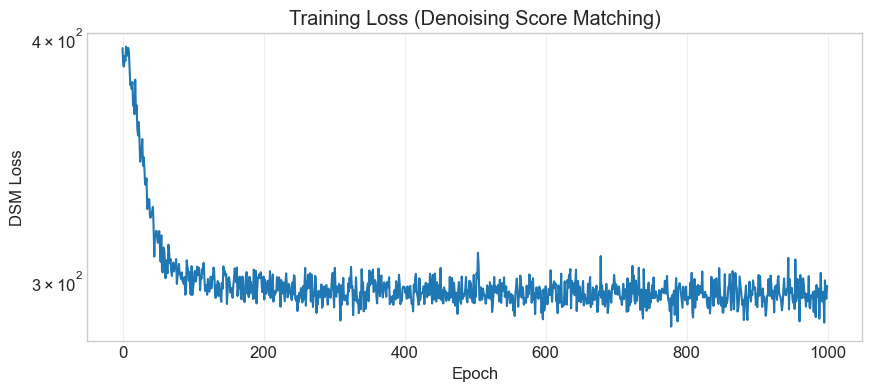

In [8]:
def train_dsm(model, data, sigma, epochs=100, batch_size=256, lr=1e-3, device='cpu'):
    """
    Train a score network using Denoising Score Matching.
    
    Args:
        model: Score network
        data: Training data, numpy array (n, dim)
        sigma: Noise level
        epochs: Number of training epochs
        batch_size: Batch size
        lr: Learning rate
        device: Device to train on
    
    Returns:
        losses: List of epoch losses
    """
    dataset = TensorDataset(torch.from_numpy(data))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for (x_0,) in dataloader:
            x_0 = x_0.to(device)
            
            # Sample noise
            epsilon = torch.randn_like(x_0)
            
            # Create noisy data
            x_noisy = x_0 + sigma * epsilon
            
            # Predict score
            score_pred = model(x_noisy)
            
            # Target score: -epsilon / sigma
            score_target = -epsilon / sigma 
            
            # DSM loss
            loss = F.mse_loss(score_pred, score_target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.6f}")
    
    return losses


# Training parameters
SIGMA = 0.05  # Noise level - this is a crucial hyperparameter!

# Train on spiral data
print(f"Training Score Network on Spiral data (σ = {SIGMA})...\n")
score_model = ScoreNetwork(data_dim=2, hidden_dim=256, num_layers=4).to(device)
losses = train_dsm(score_model, spiral_data, sigma=SIGMA, epochs=1000, lr=0.001, device=device)

# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('DSM Loss')
plt.title('Training Loss (Denoising Score Matching)')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

### Visualizing the Learned Score Field

/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


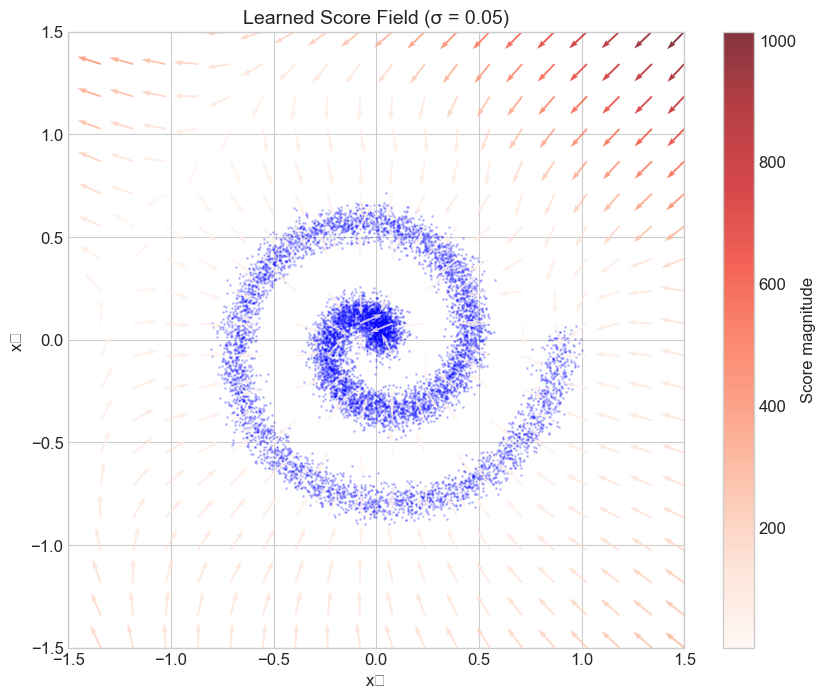

Observation: Arrows point toward the spiral — the model learned to denoise!


In [9]:
@torch.no_grad()
def visualize_score_field(model, data, title, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), grid_size=20):
    """
    Visualize the learned score field as arrows on a grid.
    """
    model.eval()
    
    # Create grid
    x_range = np.linspace(xlim[0], xlim[1], grid_size)
    y_range = np.linspace(ylim[0], ylim[1], grid_size)
    X, Y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([X.flatten(), Y.flatten()], axis=1).astype(np.float32)
    
    # Get scores
    grid_tensor = torch.from_numpy(grid_points).to(device)
    scores = model(grid_tensor).cpu().numpy()
    
    U = scores[:, 0].reshape(X.shape)
    V = scores[:, 1].reshape(X.shape)
    
    # Normalize arrows for better visualization
    magnitude = np.sqrt(U**2 + V**2)
    U_norm = U / (magnitude + 1e-6)
    V_norm = V / (magnitude + 1e-6)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.2, c='blue', label='Data')
    
    # Color arrows by magnitude
    plt.quiver(X, Y, U_norm, V_norm, magnitude.flatten(), cmap='Reds', alpha=0.8, scale=25)
    plt.colorbar(label='Score magnitude')
    
    plt.title(title, fontsize=14)
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().set_aspect('equal')
    plt.show()

visualize_score_field(score_model, spiral_data, 
                      f'Learned Score Field (σ = {SIGMA})')

print("Observation: Arrows point toward the spiral — the model learned to denoise!")

## 8. Sampling with Langevin Dynamics

Given a learned score function, we can sample using **Langevin Monte Carlo**:

$$x_{t+1} = x_t + \frac{\epsilon}{2} \nabla_x \log p(x_t) + \sqrt{\epsilon} \, z_t$$

where:
- $\epsilon$ is the step size
- $z_t \sim \mathcal{N}(0, I)$ is random noise
- As $\epsilon \to 0$ and $t \to \infty$, samples converge to $p(x)$

### Intuition

1. **Gradient term:** Moves toward high-density regions
2. **Noise term:** Allows exploration (prevents getting stuck)

This is essentially "gradient ascent with noise" on the log-density.

In [10]:
@torch.no_grad()
def langevin_dynamics(model, n_samples, n_steps, step_size, sigma, 
                      init_std=1.5, return_trajectory=False, device='cpu'):
    """
    Sample using Langevin dynamics with learned score.
    
    Args:
        model: Trained score network
        n_samples: Number of samples to generate
        n_steps: Number of Langevin steps
        step_size: Langevin step size (epsilon)
        sigma: Noise level used during training
        init_std: Std for initial random samples
        return_trajectory: If True, return intermediate steps
        device: Device to run on
    
    Returns:
        samples: Final samples, shape (n_samples, 2)
        trajectory (optional): List of intermediate samples
    """
    model.eval()
    
    # Initialize from random noise
    x = init_std * torch.randn(n_samples, 2, device=device)
    
    trajectory = [x.cpu().numpy()] if return_trajectory else None
    
    for t in range(n_steps):
        # Get score
        score = model(x)
        
        # Langevin update
        noise = torch.randn_like(x)
        x = x + (step_size / 2) * score + np.sqrt(step_size) * noise
        
        # Save trajectory
        if return_trajectory and (t % (n_steps // 10) == 0 or t == n_steps - 1):
            trajectory.append(x.cpu().numpy())
    
    if return_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()


# Generate samples
print("Sampling with Langevin dynamics...")
samples, trajectory = langevin_dynamics(
    score_model, 
    n_samples=5000, 
    n_steps=2000, 
    step_size=0.0001,
    sigma=SIGMA,
    init_std=1.5,
    return_trajectory=True,
    device=device
)
print(f"Generated {len(samples)} samples")

Sampling with Langevin dynamics...
Generated 5000 samples


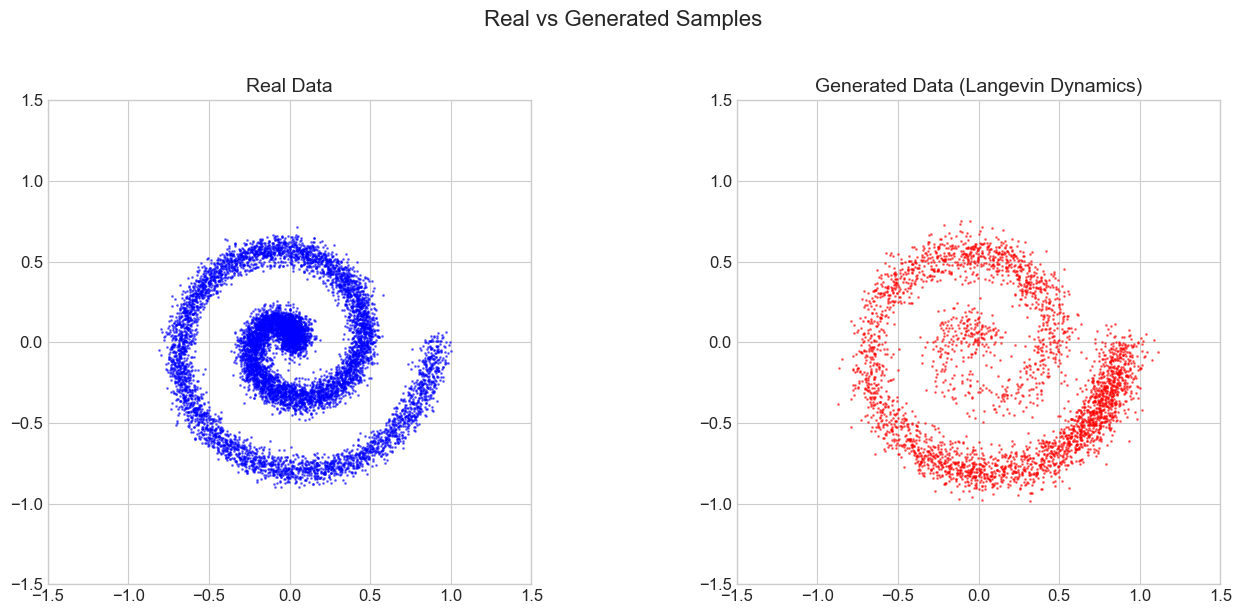

In [11]:
# Compare real and generated data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real data
axes[0].scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, alpha=0.5, c='blue')
axes[0].set_title('Real Data', fontsize=14)
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_aspect('equal')

# Generated data
axes[1].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title('Generated Data (Langevin Dynamics)', fontsize=14)
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_aspect('equal')

plt.suptitle('Real vs Generated Samples', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Visualizing the Langevin Sampling Trajectory

Let's see how particles evolve from random noise to the data distribution:

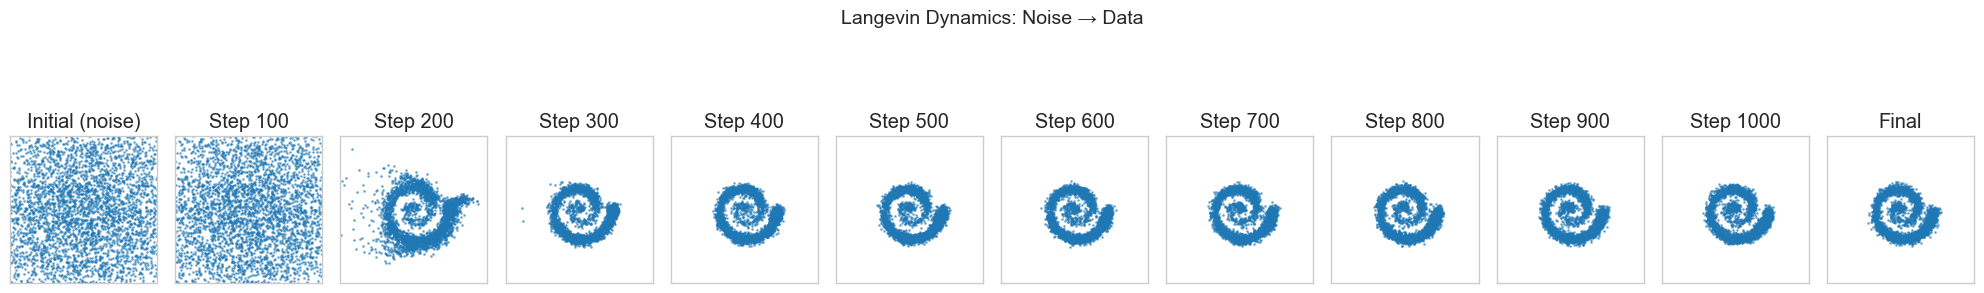

In [12]:
# Show trajectory snapshots
n_snapshots = len(trajectory)
fig, axes = plt.subplots(1, n_snapshots, figsize=(20, 3.5))

for idx, data in enumerate(trajectory):
    axes[idx].scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
    
    if idx == 0:
        step_label = "Initial (noise)"
    elif idx == len(trajectory) - 1:
        step_label = "Final"
    else:
        step_label = f"Step {idx * 100}"
    
    axes[idx].set_title(step_label)
    axes[idx].set_xlim(-2, 2)
    axes[idx].set_ylim(-2, 2)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.suptitle('Langevin Dynamics: Noise → Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

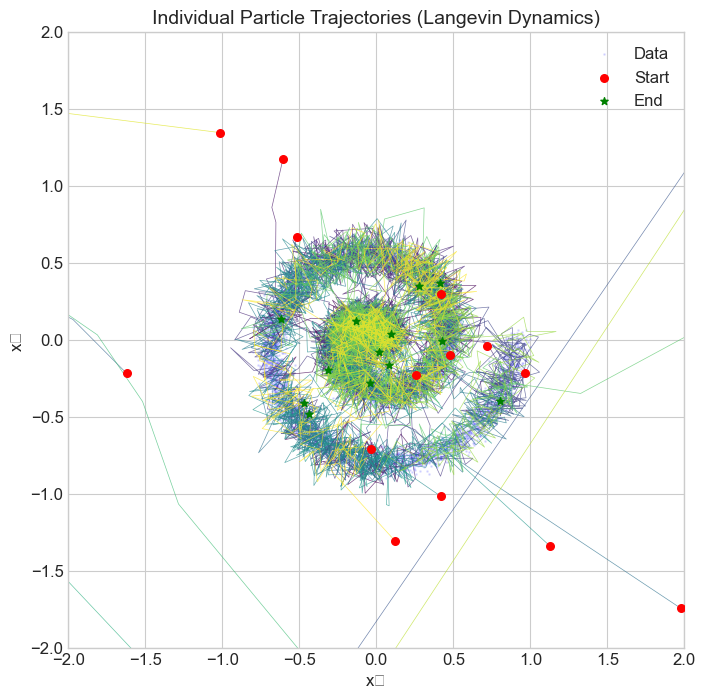

Particles start from random positions (red) and flow toward the data (green)!


In [13]:
# Visualize individual particle trajectories
@torch.no_grad()
def langevin_with_full_trajectory(model, n_particles, n_steps, step_size, device='cpu'):
    """Track full trajectory for a few particles."""
    model.eval()
    
    x = 1.5 * torch.randn(n_particles, 2, device=device)
    trajectories = [x.cpu().numpy()]
    
    for t in range(n_steps):
        score = model(x)
        noise = torch.randn_like(x)
        x = x + (step_size / 2) * score + np.sqrt(step_size) * noise
        trajectories.append(x.cpu().numpy())
    
    return np.array(trajectories)  # (n_steps+1, n_particles, 2)

# Get trajectories for a few particles
particle_trajectories = langevin_with_full_trajectory(
    score_model, n_particles=20, n_steps=500, step_size=0.01, device=device
)

plt.figure(figsize=(10, 8))

# Plot data in background
plt.scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, alpha=0.1, c='blue', label='Data')

# Plot particle trajectories
colors = plt.cm.viridis(np.linspace(0, 1, particle_trajectories.shape[1]))
for i in range(particle_trajectories.shape[1]):
    traj = particle_trajectories[:, i, :]
    plt.plot(traj[:, 0], traj[:, 1], '-', color=colors[i], alpha=0.7, linewidth=0.5)
    plt.scatter(traj[0, 0], traj[0, 1], c='red', s=30, marker='o', zorder=5)  # start
    plt.scatter(traj[-1, 0], traj[-1, 1], c='green', s=30, marker='*', zorder=5)  # end

plt.scatter([], [], c='red', s=30, marker='o', label='Start')
plt.scatter([], [], c='green', s=30, marker='*', label='End')

plt.title('Individual Particle Trajectories (Langevin Dynamics)', fontsize=14)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

print("Particles start from random positions (red) and flow toward the data (green)!")

## 9. Experiments: Effect of Noise Level σ

The noise level σ is crucial:
- **Too small:** Score is only defined near the data; sampling from far away fails
- **Too large:** Data structure is destroyed; score becomes uninformative
- **Just right:** Good coverage of space while preserving structure

In [14]:
def experiment_sigma(sigmas, data, epochs=150):
    """
    Train models with different noise levels and compare.
    """
    results = {}
    
    for sigma in sigmas:
        print(f"\n{'='*50}")
        print(f"Training with σ = {sigma}")
        print(f"{'='*50}")
        
        # Train model
        model = ScoreNetwork(data_dim=2, hidden_dim=256, num_layers=4).to(device)
        losses = train_dsm(model, data, sigma=sigma, epochs=epochs, lr=0.001, device=device)
        
        # Generate samples
        samples = langevin_dynamics(
            model, n_samples=5000, n_steps=2000,  init_std=1.5,
            step_size=0.0001, sigma=sigma, device=device
        )
        
        results[sigma] = {'model': model, 'losses': losses, 'samples': samples}
    
    return results

# Run experiment
sigmas_to_test = [0.05, 0.2, 0.5, 1.0]
sigma_results = experiment_sigma(sigmas_to_test, spiral_data, epochs=1000)





Training with σ = 0.05
Epoch   1/1000 | Loss: 405.036241
Epoch  20/1000 | Loss: 370.860077
Epoch  40/1000 | Loss: 332.222490
Epoch  60/1000 | Loss: 306.155256
Epoch  80/1000 | Loss: 299.951529
Epoch 100/1000 | Loss: 294.952907
Epoch 120/1000 | Loss: 304.502674
Epoch 140/1000 | Loss: 298.095489
Epoch 160/1000 | Loss: 298.634218
Epoch 180/1000 | Loss: 297.143543
Epoch 200/1000 | Loss: 304.249375
Epoch 220/1000 | Loss: 295.962072
Epoch 240/1000 | Loss: 301.296598
Epoch 260/1000 | Loss: 296.146754
Epoch 280/1000 | Loss: 303.699090
Epoch 300/1000 | Loss: 299.357772
Epoch 320/1000 | Loss: 298.135514
Epoch 340/1000 | Loss: 298.019788
Epoch 360/1000 | Loss: 298.055710
Epoch 380/1000 | Loss: 291.528889
Epoch 400/1000 | Loss: 299.433319
Epoch 420/1000 | Loss: 299.028716
Epoch 440/1000 | Loss: 293.582191
Epoch 460/1000 | Loss: 298.766391
Epoch 480/1000 | Loss: 291.163053
Epoch 500/1000 | Loss: 296.069118
Epoch 520/1000 | Loss: 286.359531
Epoch 540/1000 | Loss: 291.777635
Epoch 560/1000 | Loss: 2

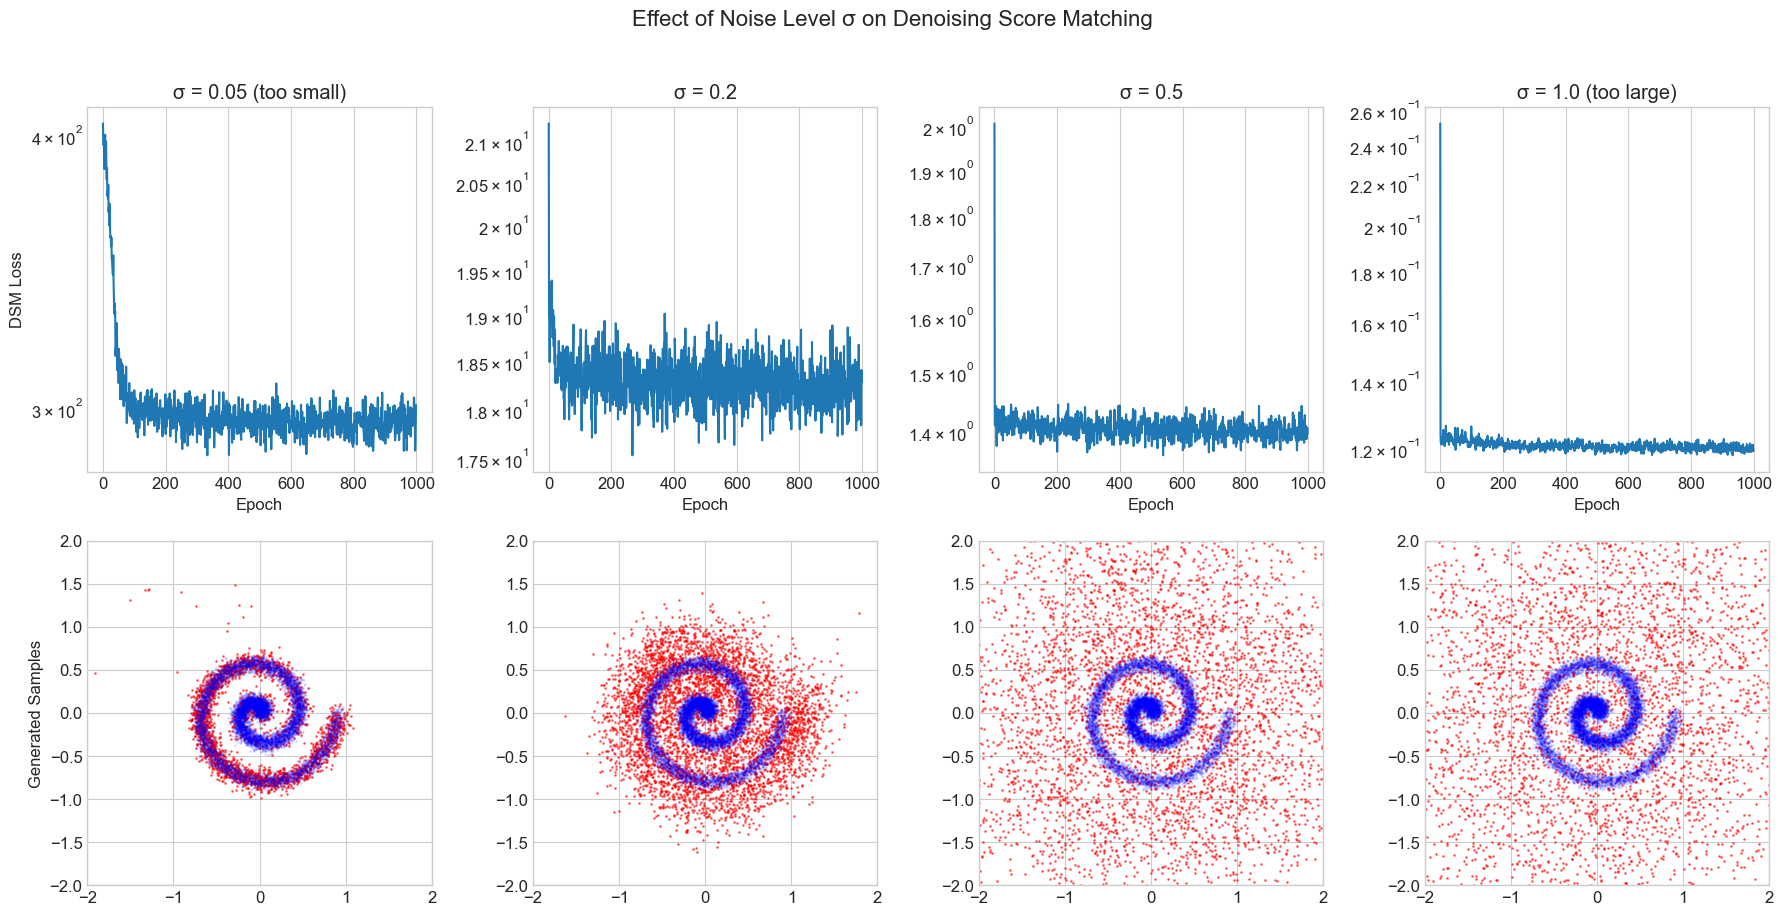


Observations:
- σ too small: Model only learns near the data; sampling from far away fails
- σ too large: Data structure is blurred; generated samples are diffuse
- σ just right: Good balance between coverage and structure preservation


In [15]:
# Visualize results
fig, axes = plt.subplots(2, len(sigmas_to_test), figsize=(18, 9))

for idx, sigma in enumerate(sigmas_to_test):
    results = sigma_results[sigma]
    
    # Top row: Training loss
    axes[0, idx].plot(results['losses'])
    axes[0, idx].set_title(f'σ = {sigma}')
    axes[0, idx].set_xlabel('Epoch')
    if idx == 0:
        axes[0, idx].set_ylabel('DSM Loss')
    axes[0, idx].set_yscale('log')
    
    # Bottom row: Generated samples
    axes[1, idx].scatter(results['samples'][:, 0], results['samples'][:, 1], 
                         s=1, alpha=0.5, c='red')
    axes[1, idx].scatter(spiral_data[:, 0], spiral_data[:, 1], 
                         s=1, alpha=0.1, c='blue')
    axes[1, idx].set_xlim(-2, 2)
    axes[1, idx].set_ylim(-2, 2)
    axes[1, idx].set_aspect('equal')
    if idx == 0:
        axes[1, idx].set_ylabel('Generated Samples')

axes[0, 0].set_title(f'σ = {sigmas_to_test[0]} (too small)')
axes[0, -1].set_title(f'σ = {sigmas_to_test[-1]} (too large)')

plt.suptitle('Effect of Noise Level σ on Denoising Score Matching', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- σ too small: Model only learns near the data; sampling from far away fails")
print("- σ too large: Data structure is blurred; generated samples are diffuse")
print("- σ just right: Good balance between coverage and structure preservation")

## 10. Connection to DDPM: Score ↔ Noise Prediction

A beautiful result: **DDPM's noise prediction is equivalent to score estimation!**

Recall from DDPM:
- Noisy data: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
- Network predicts: $\epsilon_\theta(x_t, t)$

The score of $q(x_t | x_0)$ is:
$$\nabla_{x_t} \log q(x_t | x_0) = -\frac{x_t - \sqrt{\bar{\alpha}_t} x_0}{1 - \bar{\alpha}_t} = -\frac{\epsilon}{\sqrt{1-\bar{\alpha}_t}}$$

Therefore:
$$s_\theta(x_t, t) = -\frac{\epsilon_\theta(x_t, t)}{\sqrt{1-\bar{\alpha}_t}}$$

### The Equivalence

| DDPM | Score Matching |
|------|----------------|
| Predict noise $\epsilon$ | Predict score $\nabla_x \log p$ |
| Ancestral sampling | Langevin dynamics |
| Multiple noise levels (via $t$) | Single or multiple noise levels |
| $\epsilon = -\sigma \cdot s$ | $s = -\epsilon / \sigma$ |

## 11. Limitations of Single-Noise DSM

### The Problem

With a single noise level, we face a dilemma:

1. **Small σ:** Accurate score near data, but undefined far away
   - Langevin dynamics can get stuck if initialized far from data
   
2. **Large σ:** Score defined everywhere, but blurs fine structure
   - Generated samples lack detail

### The Solution: Multi-Scale Score Matching (NCSN)

Song & Ermon (2019) proposed using **multiple noise levels**:

$$\sigma_1 > \sigma_2 > \ldots > \sigma_L$$

- Train a **noise-conditional** score network: $s_\theta(x, \sigma)$
- Sample using **annealed Langevin dynamics:**
  1. Start with large σ (coarse structure)
  2. Gradually decrease to small σ (fine details)

This is exactly what DDPM does with its noise schedule!

Demonstrating annealed Langevin dynamics (multi-scale)...
(Using separately trained models as a proxy for a noise-conditional network)



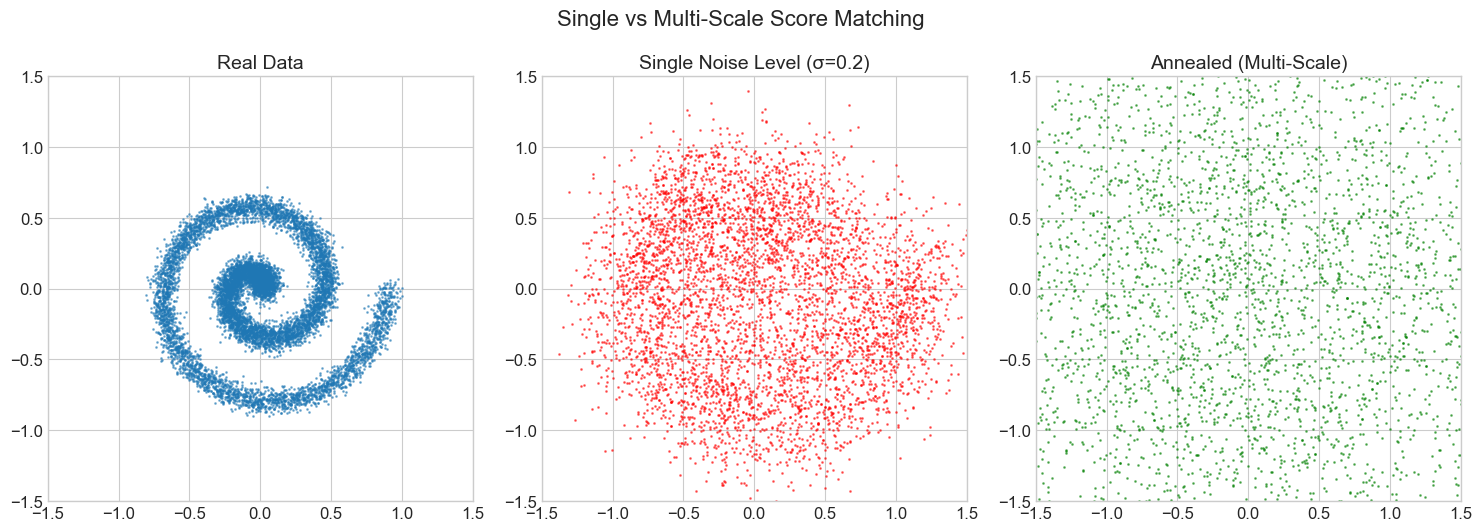

In [17]:
# Demonstrate the benefit of annealing (using our trained models at different σ)
print("Demonstrating annealed Langevin dynamics (multi-scale)...")
print("(Using separately trained models as a proxy for a noise-conditional network)\n")

@torch.no_grad()
def annealed_langevin(models_by_sigma, sigmas, n_samples, steps_per_sigma, step_size, device):
    """
    Annealed Langevin dynamics using multiple noise-level models.
    """
    # Start from noise
    x = 1.5 * torch.randn(n_samples, 2, device=device)
    trajectory = [x.cpu().numpy()]
    
    # Anneal through noise levels (large to small)
    for sigma in sorted(sigmas, reverse=True):
        model = models_by_sigma[sigma]
        model.eval()
        
        for t in range(steps_per_sigma):
            score = model(x)
            noise = torch.randn_like(x)
            # Use sigma-dependent step size
            eps = step_size * (sigma ** 2)
            x = x + (eps / 2) * score + np.sqrt(eps) * noise
        
        trajectory.append(x.cpu().numpy())
    
    return x.cpu().numpy(), trajectory

# Get models from sigma experiment
models_dict = {sigma: sigma_results[sigma]['model'] for sigma in sigmas_to_test}

# Run annealed Langevin
annealed_samples, annealed_traj = annealed_langevin(
    models_dict, sigmas_to_test, 
    n_samples=5000, steps_per_sigma=2000, step_size=0.0001,   device=device
)







# Compare single-sigma vs annealed
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(spiral_data[:, 0], spiral_data[:, 1], s=1, alpha=0.5)
axes[0].set_title('Real Data', fontsize=14)

# Best single-sigma result
best_sigma = 0.2
axes[1].scatter(sigma_results[best_sigma]['samples'][:, 0], 
                sigma_results[best_sigma]['samples'][:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title(f'Single Noise Level (σ={best_sigma})', fontsize=14)

axes[2].scatter(annealed_samples[:, 0], annealed_samples[:, 1], s=1, alpha=0.5, c='green')
axes[2].set_title('Annealed (Multi-Scale)', fontsize=14)

for ax in axes:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

plt.suptitle('Single vs Multi-Scale Score Matching', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()